# Transfer learning

Trasfer learning is a machine learning method through which the experienced obtained solving a determined problem is used to speed up the solution of a similar (yet different) problem. 

In the case of reinforcement learning, we start by training an agent to solve our optimization problem under the action of a Hamiltonian. Then, we can exploit the knowledge of such agent to solve the same problem under a perturbation of the original Hamiltonian. In order to do so, instead of restarting the learning process from scratch, we will take the trained agent from the first problem as starting point to solve the second problem.

`DQNTrainer` provides two ways of doing transfer learning. The most straightfoward method is by, simply, training the agents to solve a problem and, then, change the already existing environment and some of the agent hyper-parameters to solve the second problem. The second approach consists on instancing a new `DQNTrainer` for the second problem providing it with an `agent.model` list containing the pre-trained newtorks. This is pretty handy once we have some pre-trained agents from other problems that we want to try. 

In [ ]:
from bounce.hamiltonian import XXHamiltonian
from bounce.budget_profiles import FlatProfile
from bounce.training import DQNTrainer
from bounce.utils import arrange_shape, best_so_far, load_model, plot_trainings
from bounce.utils import convergence_time, get_indiv_times

import numpy as np
import pickle
from tqdm.auto import tqdm
from pathlib import Path
from copy import deepcopy
from collections import deque
from matplotlib import pyplot as plt
from nbdev.showdoc import show_doc

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Transfer learning from the beginning

When we do not have any pre-trained models to use for our task at hand, but we want to see how an agent trained in a similar and, maybe, easier problem may be of use for our task, we need to first train these agents. 

For this task, we only need one `DQNTrainer` whose paramters will be changed between tasks. 

### Problem definition

Here, we will define our two problems under the same budget restrictions: 
* The initial Hamiltonian `H1`. 
* The second Hamiltonian `H2`, similar to `H1`. 


In [ ]:
N = 6 

# Hamiltonian 1
B1, J1 = [1]*N, [i%3 for i in range(N)]
H1 = XXHamiltonian(N, np.array(B1), np.array(J1))

# Hamiltonian 2
B2, J2 = [1]*N, [0, 2, 0, 0]+[2]*2
H2 = XXHamiltonian(N, np.array(B2), np.array(J2))

#Computational budget
max_limit = 300
profile = FlatProfile(max_limit)

Let us see the two different systems

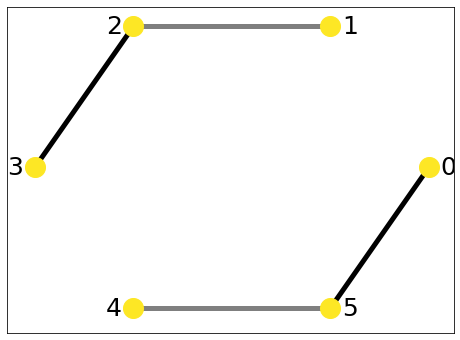

In [ ]:
H1.draw_system()

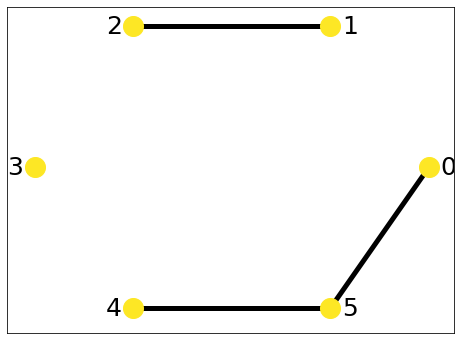

In [ ]:
H2.draw_system()

If both Hamiltonians are within the same phase, the transfer learning is completely trivial, provided that the solution of both problems is the same. 

### Agent learning parameters

In [ ]:
# Agent parameters
learning_rate = 2e-3
batch_size = 200
eps_0 = 1.
eps_decay = 0.995
target_update = 5

# Training parameters
episodes = 750
time_steps = 6
opt1 = (-10.9443, 127) 
opt2 = (-11.6569, 83)
best_ref2 = np.array([*opt2, 288]) 
n_agents, jobs = 15, 15 # Parallel trainings and cores

### Solve the first problem

Let us define the `DQNTrainer` and train an agent to find the optimal solution to the first problem.

In [ ]:
dqn = DQNTrainer(N, H1, profile, n_agents=n_agents, n_jobs=jobs,
                learning_rate=learning_rate, batch_size=batch_size, eps_decay=eps_decay, eps_0=eps_0, target_update=target_update)

In [ ]:
%time results1 = dqn.train(episodes, time_steps=time_steps, opt=opt1)

CPU times: user 27.4 s, sys: 94.8 ms, total: 27.5 s
Wall time: 1min 49s


In [ ]:
train_results1 = results1["training"]
plot_trainings(train_results1)

### Change problem

For transfer learning, we will have to change the environment and reset some of the agent attributes, such as the epsilon for exploration. 

We will have to use the methods `DQNTrainer.change_environment` and `DQNTrainer.set_agent_attrs` taking care that the agent's memory needs to be explicitly reset providing an empty deque. 

In [ ]:
dqn.change_environment(H2) # Change environment hamiltonian

In [ ]:
dqn.set_agent_attrs(epsilon=eps_0, memory=deque(maxlen=10000)) # Reset epsilon and memory

In [ ]:
%time tl_results = dqn.train(episodes, time_steps=time_steps, opt=opt2, best_ref=best_ref2, save=False)

CPU times: user 31.8 s, sys: 937 ms, total: 32.7 s
Wall time: 1min 57s


In [ ]:
train_tl_results = tl_results["training"]
plot_trainings(train_tl_results)

## Compare against solving from scratch

In order to see whether we obtain any kind of advantage with transfer learing, we need to compare the result with respect to a training without any prior knowledge.

In [ ]:
base_dqn = DQNTrainer(N, H2, profile, n_agents=n_agents, n_jobs=jobs,
                      learning_rate=learning_rate, batch_size=batch_size, eps_decay=eps_decay, eps_0=eps_0, target_update=target_update)

In [ ]:
%time base_results = base_dqn.train(episodes, time_steps=time_steps, opt=opt2, best_ref=best_ref2, save=False)

In [ ]:
train_base_results = base_results['training'] 
plot_trainings(train_base_results)

With transfer learning, we observe a significant advantage in three aspects: 
* Jumpstart advantage: at the beginning of the training, the rewards obtained with transfer learning are, on average, higher than the ones obtained without introducing prior knowledge. 
* Asymptotic advantage: by the end of the training, on average, more agents reach higher rewards and more optimal states with transfer learning. 
* Convergence advantage: with transfer learning, the convergence is much faster. Agents converge with about half the learning episodes.  

Overall, the total accumulated reward during training is higher with transfer learning as a result of a faster and better convergence to the optimal policy. 

For this whole comparison, it is important to look at the reached optimal states (red line), provided that the rewards depend on the agent's exploration. Nonetheless, they can provide an intuition of how the learning is going: better rewards imply that the agent goes towards the best it has seen. 

Let us have a look now at the differences in state-space exploration with and without transfer learning. 

In [ ]:
base_expl = base_results['exploration']
base_rewards = arrange_shape(base_expl['oracle_rewards'])
tl_expl = tl_results["exploration"]
tl_rewards = arrange_shape(tl_expl['oracle_rewards'])

plt.figure(figsize=(10, 4))
plt.plot(np.mean(best_so_far(base_rewards), axis=0), linewidth=2, label="base")
plt.plot(np.mean(best_so_far(tl_rewards), axis=0), linewidth=2, label="TL")
plt.grid()
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)
plt.xlabel("New SDP query", fontsize=20)
plt.ylabel("Best reward", fontsize=20);

In [ ]:
base_expl = base_results['exploration']
base_rewards = arrange_shape(base_expl['oracle_rewards'])
tl_expl = tl_results["exploration"]
tl_rewards = arrange_shape(tl_expl['oracle_rewards'])

plt.figure(figsize=(10, 4))
plt.plot(np.mean(best_so_far(base_rewards), axis=0), linewidth=2, label="base")
plt.plot(np.mean(best_so_far(tl_rewards), axis=0), linewidth=2, label="TL")
plt.grid()
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)
plt.xlabel("New SDP query", fontsize=20)
plt.ylabel("Best reward", fontsize=20);

Transfer learning shows an exploration advantage, provided that, initially, the agent has an intuition of what will be the configurations leading to better rewards. 

## Transfer learning from saved models

In case we have previously trained some agents and we have stored their models, we can skip the initial training part on the similar problem and go straight to solving the second problem. This method comes particulary handy when dealing with long trainings. 

In this case, we can load the models trained to solve `H1`. We use the function `load_model` which outpus a dictionary containing both the acutal pytorch model and the mdoel's state_dict. The quantities can be accessed with the keys `'model'` and `'state_dict'`. 

In [ ]:
pre_trained_models = [load_model(H1, max_limit, ID)['model'] for ID in range(n_agents)]
print(len(pre_trained_models))
print(pre_trained_models[0])

Let's now create the `DQNTrainer` to solve the second problem `H2` with the pre-trained models. Whenever we input a collection of models, `n_agents` is automatically adjusted but we still need to choose the amount of parallel threads. 

In [ ]:
dqn_from_models = DQNTrainer(N, H2, profile, models=pre_trained_models, n_jobs=len(pre_trained_models),
                             eps_0=0.9)

In [ ]:
%time results_from_models = dqn_from_models.train(episodes, time_steps=time_steps, opt=opt2, save=False)

In [ ]:
train_results_models = results_from_models['training'] 
plot_trainings(train_results_models)

## Transfer learning between phases

In the Heisenberg XX model we find two phases with very different optimal configurations. Here, we perform transfer learning from deep into one phase of the Hamiltonian to many other points across the phase space. We observe that, provided that the optimal set of constraints is the same within the unentangled phase of the Hamiltonian $B/J\geq2$, the transfer learning is trivial, while the convergence advantage diminishes sharply across different phases.

We start by defining the source task `H0` in which we will train our models for the first time. Then we define the tasks to which we will perform transfer learning `Hs`. 

In [ ]:
N = 6

# Initial Hamiltonian
B0, J0 = [5]*N, [1]*N
H0 = XXHamiltonian(N, np.array(B0), np.array(J0))

# Hamiltonians to transfer
Bs = [np.round(0.1*k, 2)*np.ones(N) for k in range(20)] + [np.round(2+0.5*k, 2)*np.ones(N) for k in range(5)]
Hs = [XXHamiltonian(N, b, J0) for b in Bs]

#Computational budget
max_limit = 185
profile = FlatProfile(max_limit)

Now we set our agent parameters and train it on the source task. The saved agents will be used as starting point for the other tasks.

In [ ]:
# Agent parameters
learning_rate = 5e-3
batch_size = 300
eps_decay = 0.996
target_update = 5

episodes = 800
time_steps = 7
n_agents, n_jobs = 60, 15 

Remember to only train the source agents once!

In [ ]:
dqn = DQNTrainer(N, H0, profile, n_agents=n_agents, n_jobs=n_jobs,
                 learning_rate=learning_rate, batch_size=batch_size, eps_decay=eps_decay, target_update=target_update)

In [ ]:
%time results = dqn.train(episodes, time_steps=time_steps, ckp=10)

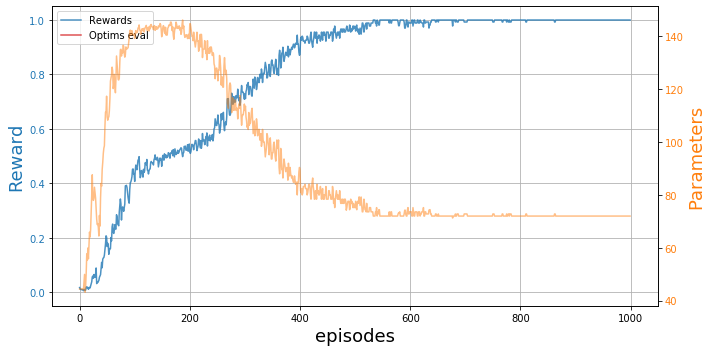

In [ ]:
plot_trainings(results['training'])

In [ ]:
TL_evaluation = {B[0]: dict.fromkeys(['tl', 'vanilla', 'time_ratio']) for B in Bs}
for H in tqdm(Hs):
    B = H.linear[0]
    pre_trained_models = [load_model(H0, max_limit, ID)['model'] for ID in range(n_agents, 2*n_agents)]
    
    dqn_cold_start = DQNTrainer(N, H, profile, n_agents=len(pre_trained_models), n_jobs=n_jobs, 
                                learning_rate=learning_rate, batch_size=batch_size, eps_decay=eps_decay, target_update=target_update)
    results = dqn_cold_start.train(episodes, time_steps=time_steps)
    time = convergence_time(results)
    TL_evaluation[B]['vanilla'] = deepcopy(results['training'])
    del dqn_cold_start; del results
    
    dqn_from_models = DQNTrainer(N, H, profile, models=pre_trained_models, n_jobs=n_jobs, 
                                 learning_rate=learning_rate, batch_size=batch_size, eps_0=eps_0, eps_decay=eps_decay, target_update=target_update)
    results_tl = dqn_from_models.train(episodes, time_steps=time_steps, save=False)
    time_tl = convergence_time(results_tl)
    TL_evaluation[B]['tl'] = deepcopy(results_tl['training'])
    del dqn_from_models; del results_tl
    
    time = convergence_time(TL_evaluation[B]['vanilla'])
    TL_evaluation[B]['time_ratio'] = time_tl/time

In [ ]:
path = Path(f"../benchmarks/TL_{H0.model}_N{N}_{max_limit}_{n_agents}_from_B{B0[0]}.pkl")
Path.mkdir(path.parent, exist_ok=True)
with open(path, 'wb') as f:
    pickle.dump(TL_evaluation, f, protocol=pickle.HIGHEST_PROTOCOL)

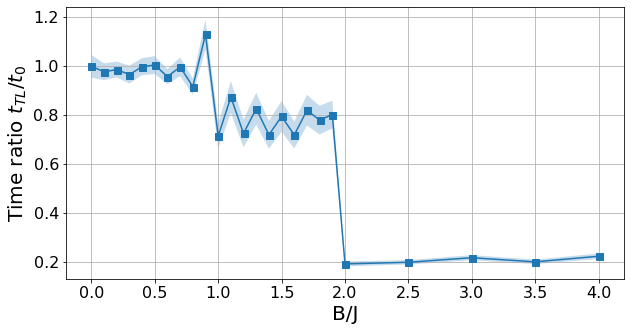

In [ ]:
Bs, time_ratios, time_errs = get_indiv_times(TL_evaluation)

plt.figure(figsize=(10, 5))
plt.fill_between(Bs, time_ratios-time_errs, time_ratios+time_errs, alpha=0.25)
plt.plot(Bs, time_ratios, 's-', ms=7)
plt.grid()
plt.tick_params(labelsize=16)
plt.xlabel("B/J", fontsize=20)
plt.ylabel(r"Time ratio $t_{TL}/t_0$", fontsize=20);